# Fuzzy Matching With Howso Engine

## Recipe Overview

This example notebook will demonstrate Howso Engine’s ability to use case Accuracy Contributions to identify centroids in the data, then use the influential cases of each centroid to conduct matching of the data. 
This form of matching that here we refer to as "Fuzzy Matching" can be used as a type of unsupervised learning that helps users of the Engine identify some regions and build their own classes that help them understand the data.

This can be thought of as similar to clustering, but this method does not fit well to a specific number of clusters without very intentional parameter tuning. This will be discussed within the notebook.

**Definitions:**
- Case Accuracy Contributions: The Accuracy Contributions for the local model as if each individual case were not in the model.

- Influential Cases:  The closest cases to the query that influence a prediction and their influence weights based on generalized distances as probability mass.

> Note: Case Accuracy Contributions is available for "targeted" workflow only. Influential case are always available.

In [1]:
import os

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from scipy.special import (
    boxcox,
    inv_boxcox,
)
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

from howso import engine
from howso.utilities import infer_feature_attributes

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

## Step 1: Generate a simple dataset

For this example, we will create a simple data set which consists of three features. 

In [2]:
# Generate simple data set with three features
blobs = make_blobs(n_samples=1000, n_features=3, centers=50, random_state=0)
df = pd.DataFrame(blobs[0], columns=['x', 'y', 'price'])

#Rescale price feature such that it is always positive
df['price'] = df['price'] + abs(df['price'].min()) + 1

# (Optional) Inverse Box-Cox transform to create a Pareto-like distribution
# df['x'] = inv_boxcox(df['x'], .5)
# df['price'] = inv_boxcox(df['price'], .25)

# Store the target cluster for demonstration evaluation
target = blobs[1]
df.shape

(1000, 3)

## Step 2: Visualize the data

Here we visualize the dataset to show the clusters. Note, the plot below is only showing two dimensions (the data contains 3 features).

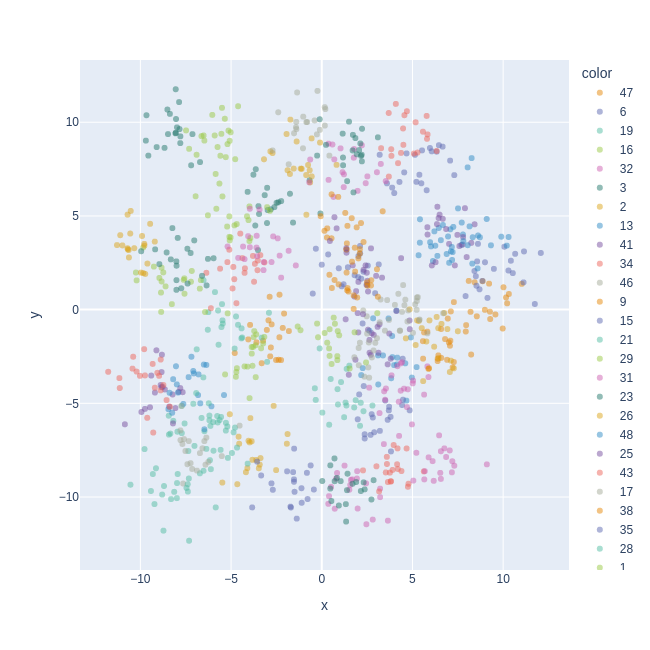

In [3]:
fig = px.scatter(
    df, x="x", y="y",
    color=pd.Series(target, dtype=str, name="Center"),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    width=650, height=650,
    opacity=0.5,
)
fig.show()

We also show some histograms for the 'X' and 'Price' features, to get a sense of the marginal distributions.

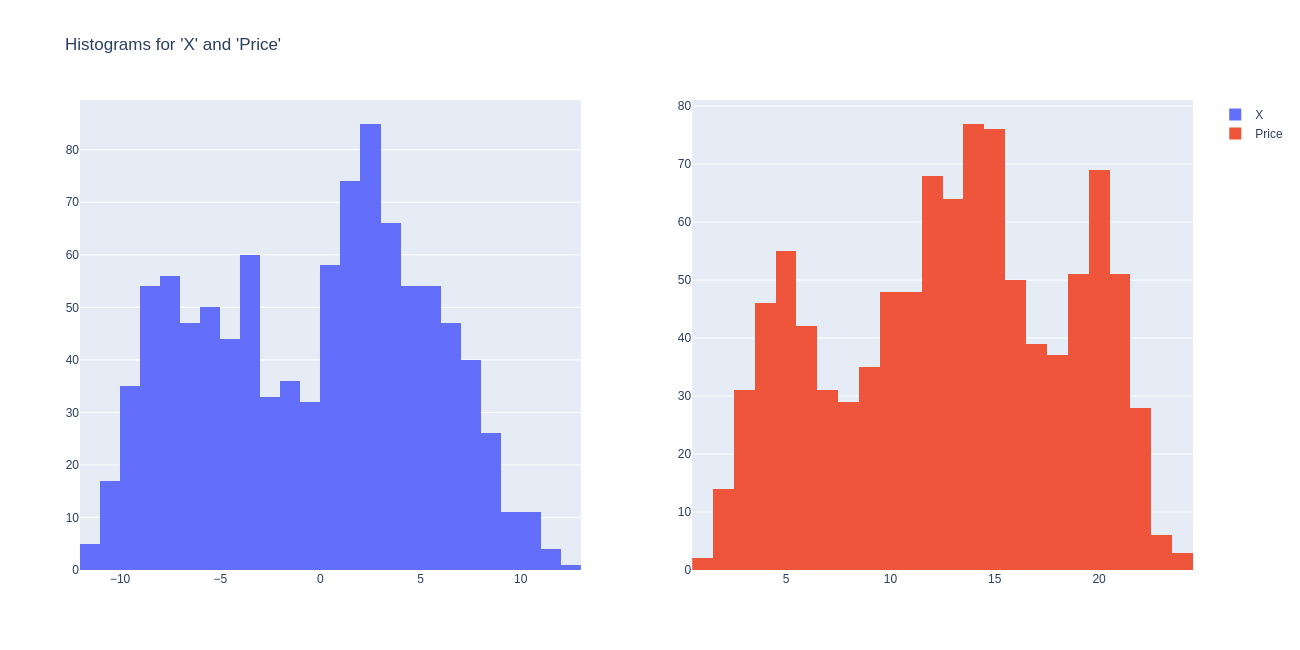

In [4]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Histogram(x=df["x"], name="X"), row=1, col=1)
fig.add_trace(go.Histogram(x=df["price"], name="Price"), row=1, col=2, )
fig.update_layout(dict(width=1300, height=650, title="Histograms for 'X' and 'Price'"))
fig.show()

## Step 3: Create a Trainee, Train, and Analyze

In this section we create a Trainee, then train and do a targeted analyze with the "price" feature as the action feature. 

First we use `infer_feature_attributes` to create feature attibutes and verify they are correct. This is always recommended.

In [5]:
# Infer the feature attributes
features = infer_feature_attributes(df)

# Inspect the feature attributes
features.to_dataframe()

type decimal_places     bounds                        \
                                        min        max allow_null   
x      continuous             19 -27.244811  27.546772       True   
y      continuous             18 -27.967231  27.393127       True   
price  continuous             16   0.000000  39.082561       True   

                                data_type original_type       
      observed_min observed_max               data_type size  
x       -11.773492    12.075453    number       numeric    8  
y       -12.335309    11.761206    number       numeric    8  
price     1.000000    24.098241    number       numeric    8

Once the feature attributes are verified, we can create the Trainee and train it. We will also store the ID of the current session.

In [6]:
# Instantiate and train the model
t = engine.Trainee(name="Engine - Fuzzy Matching Recipe",  features=features, overwrite_existing=True)
t.train(cases=df)

# Specify the context features and action feature
context_features = features.get_names(without=['price'])
action_feature ='price'

# Targeted Analyze
t.analyze(context_features=context_features, action_features=[action_feature])

# Store the session ID to retrieve training cases for later evaluation
sessions = t.get_sessions()
session_id = sessions[0]['id']
session_id

'fe248e87-ab85-412e-921c-f6713e57ee2b'

## Step 4: Identify centroids using Case Accuracy Contributions

Identify the Case Accuracy Contributions for each of the training cases. The Case Accuracy Contributions will be used to identify centroids during clustering.

To get the Case Accuracy Contributions for each case, we specify each trained case with the 'case_indices' on a call to `react` that has "case_robust_accuracy_contributions" flagged in the specified details parameter.

Then we will combine all the Case Accuracy Contributions's into a single dataframe to work with.

In [7]:
# Get a list of training cases
case_inds = t.get_cases(session=session_id, features=['.session', '.session_training_index']).values

In [8]:
# React to each case and request the Case Accuracy Contributions as a detail
# When reacting to a trained case with 'case_indices' it is recommended
# to also use the 'leave_case_out' flag.
results = t.react(case_indices=case_inds, preserve_feature_values=context_features,
                  action_features=[action_feature],
                  leave_case_out=True,
                  details={'case_robust_accuracy_contributions': True})

In [9]:
# Combine the case_Accuracy Contributions into a single DataFrame
case_ac = pd.DataFrame()

for c in results['details']['case_robust_accuracy_contributions']:
    case_ac = pd.concat([case_ac, pd.DataFrame(c)])

Once we have the Case Accuracy Contributions values for each case, we can rank them to find the cases with the highest values. We will use the top 50 cases by Case Accuracy Contributions value to be chosen as centroids. This number can be tuned, but we intentionally created a dataset with 50 clusters, so that's what we will use in this case.

In [10]:
# Rank the AC and then find the top fifty centroids. Note, the number of centroids can be tuned.
num_centers = 50
case_ac = case_ac.sort_values('accuracy_contribution', ascending=False).reset_index(drop=True)
case_ac = case_ac[~case_ac['.session_training_index'].duplicated()]
centers = case_ac[0:num_centers]

In [11]:
# The .session and .session_training_index will be used to find the influential cases in the next section
centers.head()

,.session_training_index,.session,accuracy_contribution
0,173,fe248e87-ab85-412e-921c-f6713e57ee2b,1.007263
1,941,fe248e87-ab85-412e-921c-f6713e57ee2b,0.947236
3,726,fe248e87-ab85-412e-921c-f6713e57ee2b,0.856440
5,540,fe248e87-ab85-412e-921c-f6713e57ee2b,0.841054
6,330,fe248e87-ab85-412e-921c-f6713e57ee2b,0.838529


In [12]:
# Get the case values for visualization
center_cases = t.get_cases(case_indices=centers[['.session', '.session_training_index']].values)
center_cases.head()

,price,x,y
0,24.074721,6.663419,8.698265
1,21.176786,-1.159834,7.524574
2,21.554316,3.594510,6.740187
3,21.770924,-1.106303,7.516132
4,3.221469,-0.807051,10.014079


Once we have the case values of all the cases we are selecting as centroids, we can visualize them.

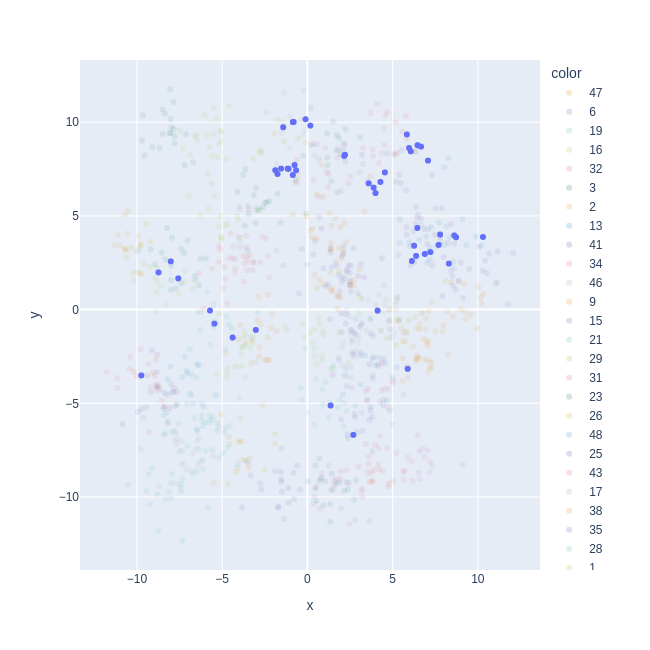

In [13]:
fig = px.scatter(
    df, x="x", y="y",
    color=pd.Series(target, dtype=str, name="Center"),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    width=650, height=650,
    opacity=0.1,
)
fig.add_trace(go.Scatter(x=center_cases["x"], y=center_cases["y"], mode="markers"))

fig.show()

## Step 5: Cluster around the centroids using their Influential cases

Use the influential cases of each centroid to cluster the data. More specifically, tag the influential cases as the same cluster as the centroid.

> Note: Most Similar cases is another `react` detail that can be used to cluster data points. 

In [14]:
# Get the influential cases and most similar cases for each of the centroids
num_similar_cases = 5
results = t.react(case_indices=centers[[".session", ".session_training_index"]].values,
                  leave_case_out=True,
                  preserve_feature_values=context_features, action_features=[action_feature],
                  details={'most_similar_cases':True, 'num_most_similar_cases':num_similar_cases, 'influential_cases':True})

In [15]:
# Tag each influential cases with the same cluster as the centroid
centers = centers.reset_index().rename(columns={'index':'target'})
clustered_df = pd.DataFrame()

for i, cases in enumerate(results['details']['influential_cases']):
    tar = centers['target'].iloc[i]
    clustered = pd.DataFrame(cases)
    clustered['target'] = tar

    clustered_df = pd.concat([clustered_df, clustered])

clustered_df = clustered_df.reset_index(drop=True)

We also put together the original trained data with their true cluster IDs that were assigned when the data was generated.

In [16]:
# Training data for evaluation purposes
df_train = t.get_cases(session=session_id, features=df.columns.tolist() + ['.session_training_index'])
df_train = df_train.join(pd.Series(target, name='target'))

df_train

,x,y,price,.session_training_index,target
0,-3.235779,-1.660880,20.497487,0,47
1,4.283446,6.814812,21.116852,1,6
2,-3.011843,-2.788841,8.100008,2,19
3,-3.863634,-1.995433,14.314644,3,16
4,1.937476,-9.014279,21.314027,4,32
...,...,...,...,...,...
995,-1.755072,7.239146,21.026818,995,2
996,-0.850211,10.007344,4.005985,996,17
997,1.363724,3.038060,19.619870,997,12
998,-8.880399,-4.024742,4.517326,998,25


In [17]:
clustered_df

,y,price,.session_training_index,x,.session,.influence_weight,target
0,8.775207,20.046285,432,6.458395,fe248e87-ab85-412e-921c-f6713e57ee2b,0.243349,0
1,8.466543,6.481190,216,6.333380,fe248e87-ab85-412e-921c-f6713e57ee2b,0.119350,0
2,8.429682,20.469734,682,6.334541,fe248e87-ab85-412e-921c-f6713e57ee2b,0.111542,0
3,8.625114,21.443353,666,5.964634,fe248e87-ab85-412e-921c-f6713e57ee2b,0.091625,0
4,8.448215,21.662777,967,6.061825,fe248e87-ab85-412e-921c-f6713e57ee2b,0.080290,0
...,...,...,...,...,...,...,...
645,8.792374,2.233728,328,0.232880,fe248e87-ab85-412e-921c-f6713e57ee2b,0.062757,132
646,8.915079,20.266021,122,-0.095924,fe248e87-ab85-412e-921c-f6713e57ee2b,0.059996,132
647,8.857585,13.570252,358,0.369683,fe248e87-ab85-412e-921c-f6713e57ee2b,0.059929,132
648,9.392112,1.528746,337,1.153988,fe248e87-ab85-412e-921c-f6713e57ee2b,0.053662,132


Then, for each cluster created using Case MDA, we determine the target cluster ID that is most common among the cluster's cases.

In [18]:
# Map each of the predicted cluster with the most commonly occurring original cluster
label_map = {}

for c in clustered_df['target'].unique():
    group_df = clustered_df[clustered_df['target'] == c]
    target_original = df_train[df_train['.session_training_index'].isin(group_df['.session_training_index'])]['target'].value_counts().idxmax()
    # print(df_train[df_train['.session_training_index'].isin(group_df['.session_training_index'])]['target'].value_counts())
    label_map[c] = target_original

clustered_df = clustered_df.replace({'target':label_map})

After this is done, we can score the accuracy of the cluster labels for the cases that were clustered.

In [19]:
# Create a single table with predicted and correct target results
correct_target = []
for i in clustered_df['.session_training_index']:
    correct_t = df_train[df_train['.session_training_index'] == i]['target'].iloc[0]
    correct_target.append(correct_t)

clustered_df['correct_target'] = correct_target
clustered_df.head()

,y,price,.session_training_index,x,.session,.influence_weight,target,correct_target
0,8.775207,20.046285,432,6.458395,fe248e87-ab85-412e-921c-f6713e57ee2b,0.243349,6,6
1,8.466543,6.481190,216,6.333380,fe248e87-ab85-412e-921c-f6713e57ee2b,0.119350,6,34
2,8.429682,20.469734,682,6.334541,fe248e87-ab85-412e-921c-f6713e57ee2b,0.111542,6,6
3,8.625114,21.443353,666,5.964634,fe248e87-ab85-412e-921c-f6713e57ee2b,0.091625,6,6
4,8.448215,21.662777,967,6.061825,fe248e87-ab85-412e-921c-f6713e57ee2b,0.080290,6,6


In [20]:
# Accuracy evaluation
acc = round(accuracy_score(clustered_df['correct_target'], clustered_df['target']), 3)
print(f'accuracy: {acc}')

accuracy: 0.588


Two dimensional representation of the identified clusters.

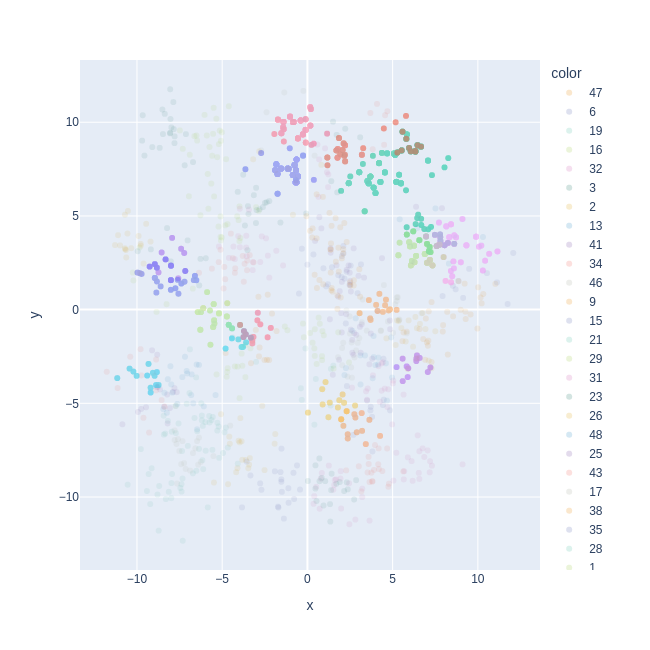

In [21]:
fig = px.scatter(
    df, x="x", y="y",
    color=pd.Series(target, dtype=str, name="Center"),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    width=650, height=650,
    opacity=0.1,
)
for group, data in clustered_df.groupby("target"):
    fig.add_trace(go.Scatter(
        x=data["x"],
        y=data["y"],
        mode="markers",
        opacity=0.5
    ))

fig.show()

## Step 6: Try different numbers of centroids

Howso Engine starts clustering with the most confident centroids (highest Case Accuracy Contributions). Therefore, the number specified centroids can have an impact on clustering performance. 

Relatively low ratio of specified clusters vs. actual number of clusters is expected to have higher accuracy. In this example, we will demonstrate the impact of the number of cluster using 10 to 50 clusters. As a ratio of specified clusters to actual clusters, these represents a ratio of 1/5 up to 1. 

However, clustering with influential cases will assign a limited number of cases to each cluster. So there is a tradeoff to be made when clustering in this manner, since a smaller number of centroids will not be able to attribute as many cases to a cluster.

In [22]:
# Number of specified clusters
num_centers = [10, 20, 30, 40, 50]

Here we define a helper function which will do all the previous code, but in a single function call for a specific number of centroids. This will make evaluation easier and more succinct.

In [23]:
# A function which finds the centroids (using case_robust_accuracy_pre), then clusters the data (using influential cases), followed by accuracy evaluation
def cluster_eval(num_centers):
    case_ac = pd.DataFrame()

    results = t.react(case_indices=case_inds, preserve_feature_values=context_features,
                  action_features=[action_feature],
                  leave_case_out=True,
                  details={'case_robust_accuracy_contributions':True})

    for c in results['details']['case_robust_accuracy_contributions']:
        case_ac = pd.concat([case_ac, pd.DataFrame(c)])

    case_ac = case_ac.sort_values('accuracy_contribution', ascending=False).reset_index(drop=True)
    case_ac = case_ac[~case_ac['.session_training_index'].duplicated()]
    centers = case_ac[0:num_centers]

    center_cases = t.get_cases(case_indices=centers[['.session', '.session_training_index']].values)

    num_similar_cases = 5

    results = t.react(case_indices=centers[['.session', '.session_training_index']].values,
                      leave_case_out=True,
                      preserve_feature_values=context_features, action_features=[action_feature],
                      details={'most_similar_cases':True, 'num_most_similar_cases':num_similar_cases, 'influential_cases':True})

    centers = centers.reset_index().rename(columns={'index':'target'})
    clustered_df = pd.DataFrame()

    for i, cases in enumerate(results['details']['influential_cases']):
        tar = centers['target'].iloc[i]
        clustered = pd.DataFrame(cases)
        clustered['target'] = tar

        clustered_df = pd.concat([clustered_df, clustered])

    clustered_df = clustered_df.reset_index(drop=True)

    df_train = t.get_cases(session=session_id, features=df.columns.tolist() + ['.session_training_index'])
    df_train = df_train.join(pd.Series(target, name='target'))

    label_map = {}

    for c in clustered_df['target'].unique():
        group_df = clustered_df[clustered_df['target'] == c]
        target_original = df_train[df_train['.session_training_index'].isin(group_df['.session_training_index'])]['target'].value_counts().idxmax()
        # print(df_train[df_train['.session_training_index'].isin(group_df['.session_training_index'])]['target'].value_counts())
        label_map[c] = target_original

    clustered_df = clustered_df.replace({'target':label_map})

    correct_target = []
    for i in  clustered_df['.session_training_index']:
        correct_t = df_train[df_train['.session_training_index'] == i]['target'].iloc[0]
        correct_target.append(correct_t)

    clustered_df['correct_target'] = correct_target

    clustered_df.head()

    return(accuracy_score(clustered_df['correct_target'], clustered_df['target']))

In [24]:
# Get the accuracy results for each of specified number of clusters
acc = []
for n in num_centers:
    acc.append(cluster_eval(n))

Then we visualize the impact on the clustering accuracy as the number of centroids varies.

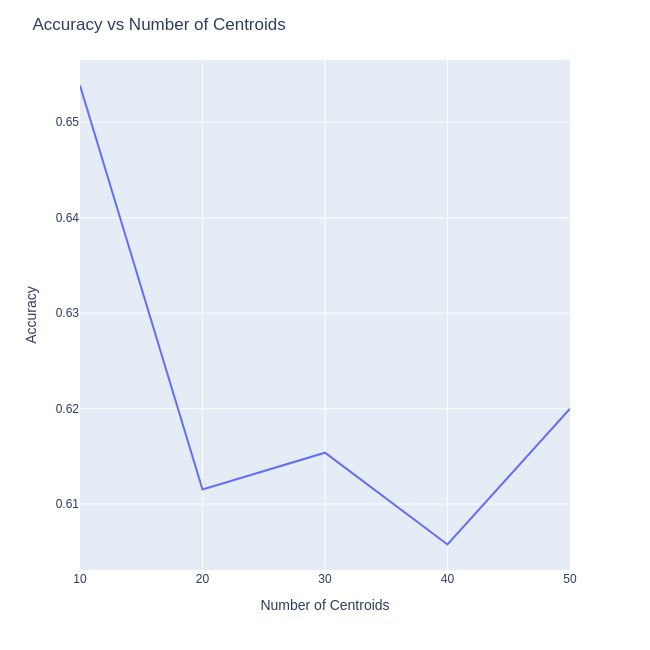

In [25]:
fig = px.line(x=num_centers, y=acc, width=650, height=650)
fig.update_layout(xaxis_title="Number of Centroids", yaxis_title="Accuracy", title='Accuracy vs Number of Centroids')
fig.show()

# Conclusion

Here we see a method of clustering that can be done using the Howso Engine. In summary, the Case Accuracy Contributions is computed for every case trained in the model and those with the largest values are chosen to be the centroids. Once centroids are selected, clusters are created by using the cases closest to each centroid, which can be found with either the "influential_cases" `react` detail or using both the "most_similar_cases" and "num_most_similar_cases" details.

We also demonstrate how this method can be affected by the number of centroids selected. We see higher accuracy with less centroids, but this typically results in less cases being clustered. 